# Warming trend and marine heat waves of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot SST time-series for a Australian Marine Park, and to detect its warming trend and potential marine heat wave events.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 16th, Jan, 2019

**Author:** Zhi Huang

**Import modules**

In [4]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
#from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between 2002 and 2018.**

<Figure size 432x288 with 0 Axes>

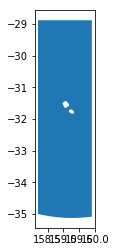

In [5]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)


#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


In [6]:
query = {'geopolygon': geom,
         'resolution': (-0.1,0.1)
         }

**Load full time-series of SST (Sea Surface Temperature), for the Lord Howe Marine Park area, from 2002 to 2018. It tooks 5 hours. Note that the resolution has been resampled from 0.01 dd to 0.1 dd to save memory usage.**

In [7]:
data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)

**Mask the nodata (-999) as 'nan'**

In [8]:
data = mask_invalid_data(data)

In [9]:
# note the time dimension: 5900
data.dims


Frozen(SortedKeysDict({'time': 5900, 'latitude': 64, 'longitude': 17}))

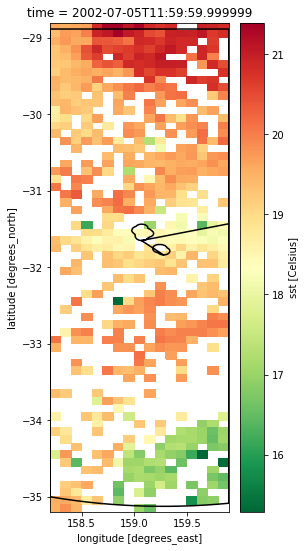

In [10]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(4,9))

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data.sst[1].plot(cmap='RdYlGn_r')

**testDF contains all SST data loaded: 3600 (90 x 40) locations (as columns) with 5900 daily time-series (as rows)**

In [11]:
testDF = pd.DataFrame()
latlonDF = pd.DataFrame()
latList = []
lonList = []
idList = []
latIndex = 0
lonIndex = 0
id = 1
while latIndex < data.latitude.size:
    while lonIndex < data.longitude.size:
        lat = data.sst[:,latIndex,lonIndex].latitude.values
        lon = data.sst[:,latIndex,lonIndex].longitude.values
        latList.append(lat)
        lonList.append(lon)
        idList.append(id)
        sstData = data.sst[:,latIndex,lonIndex].values
        testDF[id] = sstData
        id += 1
        lonIndex += 1
    latIndex += 1
    lonIndex = 0
dateList = []
i = 0
while i < data.time.size:
    date = str(data.time[i].data)[:4] + str(data.time[i].data)[5:7] + str(data.time[i].data)[8:10]
    dateList.append(date)
    i += 1
testDF['date'] = dateList
testDF.set_index('date', inplace=True)
latlonDF['id'] = idList
latlonDF['lat'] = latList
latlonDF['lon'] = lonList
latlonDF.set_index('id', inplace=True)

In [12]:
latlonDF.shape

(1088, 2)

In [77]:
latlonDF = latlonDF.drop(1,axis=0)

In [13]:
testDF.shape

(5900, 1088)

**The pad function interpolate over missing data in a time series. Courtesy of Hobday's marine heat waves codes**

In [14]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


**The four Feb 29 dates from the leap years are drop to facilitate the MHW analysis**

In [15]:
testDF1 = testDF.drop(['20040229','20080229','20120229','20160229'])

**Calculate the dayofyear for each date, and add it to the DataFrame. 
Note that the removal of the Feb 29 dates results in the matching of the dayofyear across years**

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
i = 0
dayofyears = []

while i < testDF1.index.size:
    date = testDF1.index[i]
    year = date[:4]
    ## remove the four Feb 29 in the leap years from the collection
   
    ## calculate dayofyear
    ## because the 4 Feb-29 dates have been removed, the dayofyears for all years are now matched
    dayofyear = datetime.strptime(date,'%Y%m%d').timetuple().tm_yday
    if (year == '2004') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2008') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2012') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    if (year == '2016') & (dayofyear > 60):
        dayofyear = dayofyear - 1
    print(date)
    print(dayofyear)

    dayofyears.append(dayofyear)

    i = i + 1
testDF1['dayofyear']=dayofyears



20020704
185
20020705
186
20020706
187
20020707
188
20020708
189
20020709
190
20020710
191
20020711
192
20020712
193
20020713
194
20020714
195
20020715
196
20020716
197
20020717
198
20020718
199
20020719
200
20020720
201
20020721
202
20020722
203
20020723
204
20020724
205
20020725
206
20020726
207
20020727
208
20020728
209
20020729
210
20020807
219
20020808
220
20020809
221
20020810
222
20020811
223
20020812
224
20020813
225
20020814
226
20020815
227
20020816
228
20020817
229
20020818
230
20020819
231
20020820
232
20020821
233
20020822
234
20020823
235
20020824
236
20020825
237
20020826
238
20020827
239
20020828
240
20020829
241
20020830
242
20020831
243
20020901
244
20020902
245
20020903
246
20020904
247
20020905
248
20020906
249
20020907
250
20020908
251
20020909
252
20020910
253
20020911
254
20020912
255
20020913
256
20020914
257
20020915
258
20020916
259
20020917
260
20020918
261
20020919
262
20020920
263
20020921
264
20020922
265
20020923
266
20020924
267
20020925
268
20020926
269

20050830
242
20050831
243
20050901
244
20050902
245
20050903
246
20050904
247
20050905
248
20050906
249
20050907
250
20050908
251
20050909
252
20050910
253
20050911
254
20050912
255
20050913
256
20050914
257
20050915
258
20050916
259
20050917
260
20050918
261
20050919
262
20050920
263
20050921
264
20050922
265
20050923
266
20050924
267
20050925
268
20050926
269
20050927
270
20050928
271
20050929
272
20050930
273
20051001
274
20051002
275
20051003
276
20051004
277
20051005
278
20051006
279
20051007
280
20051008
281
20051009
282
20051010
283
20051011
284
20051012
285
20051013
286
20051014
287
20051015
288
20051016
289
20051017
290
20051018
291
20051019
292
20051020
293
20051021
294
20051022
295
20051023
296
20051024
297
20051025
298
20051026
299
20051027
300
20051028
301
20051029
302
20051030
303
20051031
304
20051101
305
20051102
306
20051103
307
20051104
308
20051105
309
20051106
310
20051107
311
20051108
312
20051109
313
20051110
314
20051111
315
20051112
316
20051113
317
20051114
318

20080529
149
20080530
150
20080531
151
20080601
152
20080602
153
20080603
154
20080604
155
20080605
156
20080606
157
20080607
158
20080608
159
20080609
160
20080610
161
20080611
162
20080612
163
20080613
164
20080614
165
20080615
166
20080616
167
20080617
168
20080618
169
20080619
170
20080620
171
20080621
172
20080622
173
20080623
174
20080624
175
20080625
176
20080626
177
20080627
178
20080628
179
20080629
180
20080630
181
20080701
182
20080702
183
20080703
184
20080704
185
20080705
186
20080706
187
20080707
188
20080708
189
20080709
190
20080710
191
20080711
192
20080712
193
20080713
194
20080714
195
20080715
196
20080716
197
20080717
198
20080718
199
20080719
200
20080720
201
20080721
202
20080722
203
20080723
204
20080724
205
20080725
206
20080726
207
20080727
208
20080728
209
20080729
210
20080730
211
20080731
212
20080801
213
20080802
214
20080803
215
20080804
216
20080805
217
20080806
218
20080807
219
20080808
220
20080809
221
20080810
222
20080811
223
20080812
224
20080813
225

68
20120310
69
20120311
70
20120312
71
20120313
72
20120314
73
20120315
74
20120316
75
20120317
76
20120318
77
20120319
78
20120320
79
20120321
80
20120322
81
20120323
82
20120324
83
20120325
84
20120326
85
20120327
86
20120328
87
20120329
88
20120330
89
20120331
90
20120401
91
20120402
92
20120403
93
20120404
94
20120405
95
20120406
96
20120407
97
20120408
98
20120409
99
20120410
100
20120411
101
20120412
102
20120413
103
20120414
104
20120415
105
20120416
106
20120417
107
20120418
108
20120419
109
20120420
110
20120421
111
20120422
112
20120423
113
20120424
114
20120425
115
20120426
116
20120427
117
20120428
118
20120429
119
20120430
120
20120501
121
20120502
122
20120503
123
20120504
124
20120505
125
20120506
126
20120507
127
20120508
128
20120509
129
20120510
130
20120511
131
20120512
132
20120513
133
20120514
134
20120515
135
20120516
136
20120517
137
20120518
138
20120519
139
20120520
140
20120521
141
20120522
142
20120523
143
20120524
144
20120525
145
20120526
146
20120527
147
2

20140130
30
20140131
31
20140201
32
20140202
33
20140203
34
20140204
35
20140205
36
20140206
37
20140207
38
20140208
39
20140209
40
20140210
41
20140211
42
20140212
43
20140213
44
20140214
45
20140215
46
20140216
47
20140217
48
20140218
49
20140219
50
20140220
51
20140221
52
20140222
53
20140223
54
20140224
55
20140225
56
20140226
57
20140227
58
20140228
59
20140301
60
20140302
61
20140303
62
20140304
63
20140305
64
20140306
65
20140307
66
20140308
67
20140309
68
20140310
69
20140311
70
20140312
71
20140313
72
20140314
73
20140315
74
20140316
75
20140317
76
20140318
77
20140319
78
20140320
79
20140321
80
20140322
81
20140323
82
20140324
83
20140325
84
20140326
85
20140327
86
20140328
87
20140329
88
20140330
89
20140331
90
20140401
91
20140402
92
20140403
93
20140404
94
20140405
95
20140406
96
20140407
97
20140408
98
20140409
99
20140410
100
20140411
101
20140412
102
20140413
103
20140414
104
20140415
105
20140416
106
20140417
107
20140418
108
20140419
109
20140420
110
20140421
111
2014

69
20170311
70
20170312
71
20170313
72
20170314
73
20170315
74
20170316
75
20170317
76
20170318
77
20170319
78
20170320
79
20170321
80
20170322
81
20170323
82
20170324
83
20170325
84
20170326
85
20170327
86
20170328
87
20170329
88
20170330
89
20170331
90
20170401
91
20170402
92
20170403
93
20170404
94
20170405
95
20170406
96
20170407
97
20170408
98
20170409
99
20170410
100
20170411
101
20170412
102
20170413
103
20170414
104
20170415
105
20170416
106
20170417
107
20170418
108
20170419
109
20170420
110
20170421
111
20170422
112
20170423
113
20170424
114
20170425
115
20170426
116
20170427
117
20170428
118
20170429
119
20170430
120
20170501
121
20170502
122
20170503
123
20170504
124
20170505
125
20170506
126
20170507
127
20170508
128
20170509
129
20170510
130
20170511
131
20170512
132
20170513
133
20170514
134
20170515
135
20170516
136
20170517
137
20170518
138
20170519
139
20170520
140
20170521
141
20170522
142
20170523
143
20170524
144
20170525
145
20170526
146
20170527
147
20170528
148


In [24]:
testDF1.columns.size

1089

**The testIDF1 is generated from testDF1 after applying the interpolation (pad) function**

In [17]:
testIDF1 = pd.DataFrame()
interpolatedSSTList = []
i = 1
while i < testDF1.columns.size:
    sst = testDF1[i].values
    if np.isnan(sst).all():
        print(i, 'no data')
        latlonDF = latlonDF.drop(i, axis=0)
    else:
        interpolatedSST = pad(sst,maxPadLength=2)
        testIDF1[i] = interpolatedSST
    i += 1
testIDF1['date'] = testDF1.index
testIDF1['dayofyear'] = testDF1['dayofyear'].values
testIDF1.set_index('date', inplace=True)

In [18]:
testIDF1.columns.size

1089

**The nintypercentile function**

In [19]:
def nintypercentile(x):
    z = x.quantile(0.9)
    return(z)


**The 90 percentile is used as the threshold to identify the MHWs.
The SST values of the same dayofyear are grouped. The 90 percentile is then calculated for each group**

In [99]:
# 90th percentile from testIDF1
nintyDF = pd.DataFrame()

i = 1
while i < 3601:
    print(str(i))
    sst_series_g = testIDF1[i].groupby(testIDF1['dayofyear'])
    sst_90 = sst_series_g.transform(nintypercentile)
    nintyDF[i] = sst_90
    i += 1
nintyDF['date'] = testDF1.index
nintyDF['dayofyear'] = testDF1['dayofyear'].values
nintyDF.set_index('date', inplace=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600


**Another way of calculating the 90 perentile threshold. This time uses a 11-days window so that 
we have a much larger number of SST values each date from which to calculate the 90 percentile.
This also smoothes the 90 percentile climatology to a large degree.**

In [353]:
# 90th percentile with 11-days window
# this one takes too long to complete
nintyDF1 = pd.DataFrame()
i = 1

while i < 3601:
    print(str(i))
    nintyList = []
    for date in testIDF1.index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF1[i] = nintyList
    i += 1
nintyDF1['date'] = testDF1.index
nintyDF1['dayofyear'] = testDF1['dayofyear'].values
nintyDF1.set_index('date', inplace=True)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600


**More efficient codes to calculate the 90 percentile climatology data with 11-days window are shown 
in the next few cells**

In [23]:
# 90th percentile with 11-days window
# this one takes much shorter to complete, as it only runs for one year cycle
nintyDF2 = pd.DataFrame()
i = 1
print('start', datetime.now())
while i < testIDF1.columns.size:
    print(str(i))
    nintyList = []
    dayofyearList = []
    for date in testIDF1.loc['20030101':'20031231'].index:
        dayofyear = testIDF1.dayofyear.loc[date]
        if np.isin(dayofyear, dayofyearList):
            break
        else:
            dayofyearList.append(dayofyear)
        if dayofyear == 1:
            dayofyears = [361,362,363,364,365,1,2,3,4,5,6]
        elif dayofyear == 2:
            dayofyears = [362,363,364,365,1,2,3,4,5,6,7]
        elif dayofyear == 3:
            dayofyears = [363,364,365,1,2,3,4,5,6,7,8]
        elif dayofyear == 4:
            dayofyears = [364,365,1,2,3,4,5,6,7,8,9]
        elif dayofyear == 5:
            dayofyears = [365,1,2,3,4,5,6,7,8,9,10]
        elif dayofyear == 365:
            dayofyears = [360,361,362,363,364,365,1,2,3,4,5]
        elif dayofyear == 364:
            dayofyears = [359,360,361,362,363,364,365,1,2,3,4]
        elif dayofyear == 363:
            dayofyears = [358,359,360,361,362,363,364,365,1,2,3]
        elif dayofyear == 362:
            dayofyears = [357,358,359,360,361,362,363,364,365,1,2]
        elif dayofyear == 361:
            dayofyears = [356,357,358,359,360,361,362,363,364,365,1]
        else:
            dayofyears = np.arange(dayofyear-5,dayofyear+6,1)
        
        #print(dayofyears)
        x = testIDF1[testIDF1.dayofyear.isin(dayofyears)][i]
        x_90 = x.quantile(0.9)
        nintyList.append(x_90)
    nintyDF2[i] = nintyList
    i += 1
#nintyDF2['date'] = testDF1.index
nintyDF2['dayofyear'] = dayofyearList
nintyDF2.set_index('dayofyear', inplace=True)
print('end', datetime.now())

start 2019-04-29 13:13:57.195291
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269

In [21]:
nintyDF3 = testIDF1.copy(deep=True)

In [24]:
print('start', datetime.now())
for date in nintyDF3.index:
    print(date)
    dayofyear = nintyDF3.dayofyear.loc[date]
    print(dayofyear)
    for doy in nintyDF2.index:
        if dayofyear == doy:
            nintyDF3.loc[date] = nintyDF2.loc[doy]
            nintyDF3.dayofyear.loc[date] = str(dayofyear)
    
print('end', datetime.now())

start 2019-04-29 13:33:52.811909
20020704
185
20020705
186.0
20020706
187.0
20020707
188.0
20020708
189.0
20020709
190.0
20020710
191.0
20020711
192.0
20020712
193.0
20020713
194.0
20020714
195.0
20020715
196.0
20020716
197.0
20020717
198.0
20020718
199.0
20020719
200.0
20020720
201.0
20020721
202.0
20020722
203.0
20020723
204.0
20020724
205.0
20020725
206.0
20020726
207.0
20020727
208.0
20020728
209.0
20020729
210.0
20020807
219.0
20020808
220.0
20020809
221.0
20020810
222.0
20020811
223.0
20020812
224.0
20020813
225.0
20020814
226.0
20020815
227.0
20020816
228.0
20020817
229.0
20020818
230.0
20020819
231.0
20020820
232.0
20020821
233.0
20020822
234.0
20020823
235.0
20020824
236.0
20020825
237.0
20020826
238.0
20020827
239.0
20020828
240.0
20020829
241.0
20020830
242.0
20020831
243.0
20020901
244.0
20020902
245.0
20020903
246.0
20020904
247.0
20020905
248.0
20020906
249.0
20020907
250.0
20020908
251.0
20020909
252.0
20020910
253.0
20020911
254.0
20020912
255.0
20020913
256.0
20020914


48.0
20050218
49.0
20050219
50.0
20050220
51.0
20050221
52.0
20050222
53.0
20050223
54.0
20050224
55.0
20050225
56.0
20050226
57.0
20050227
58.0
20050228
59.0
20050301
60.0
20050302
61.0
20050303
62.0
20050304
63.0
20050305
64.0
20050306
65.0
20050307
66.0
20050308
67.0
20050309
68.0
20050310
69.0
20050311
70.0
20050312
71.0
20050313
72.0
20050314
73.0
20050315
74.0
20050316
75.0
20050317
76.0
20050318
77.0
20050319
78.0
20050320
79.0
20050321
80.0
20050322
81.0
20050323
82.0
20050324
83.0
20050325
84.0
20050326
85.0
20050327
86.0
20050328
87.0
20050329
88.0
20050330
89.0
20050331
90.0
20050401
91.0
20050402
92.0
20050403
93.0
20050404
94.0
20050405
95.0
20050406
96.0
20050407
97.0
20050408
98.0
20050409
99.0
20050410
100.0
20050411
101.0
20050412
102.0
20050413
103.0
20050414
104.0
20050415
105.0
20050416
106.0
20050417
107.0
20050418
108.0
20050419
109.0
20050420
110.0
20050421
111.0
20050422
112.0
20050423
113.0
20050424
114.0
20050425
115.0
20050426
116.0
20050427
117.0
20050428
11

20060917
260.0
20060918
261.0
20060919
262.0
20060920
263.0
20060921
264.0
20060922
265.0
20060923
266.0
20060924
267.0
20060925
268.0
20060926
269.0
20060927
270.0
20060928
271.0
20060929
272.0
20060930
273.0
20061001
274.0
20061002
275.0
20061003
276.0
20061004
277.0
20061005
278.0
20061006
279.0
20061007
280.0
20061008
281.0
20061009
282.0
20061010
283.0
20061011
284.0
20061012
285.0
20061013
286.0
20061014
287.0
20061015
288.0
20061016
289.0
20061017
290.0
20061018
291.0
20061019
292.0
20061020
293.0
20061021
294.0
20061022
295.0
20061023
296.0
20061024
297.0
20061025
298.0
20061026
299.0
20061027
300.0
20061028
301.0
20061029
302.0
20061030
303.0
20061031
304.0
20061101
305.0
20061102
306.0
20061103
307.0
20061104
308.0
20061105
309.0
20061106
310.0
20061107
311.0
20061108
312.0
20061109
313.0
20061110
314.0
20061111
315.0
20061112
316.0
20061113
317.0
20061114
318.0
20061115
319.0
20061116
320.0
20061117
321.0
20061118
322.0
20061119
323.0
20061120
324.0
20061121
325.0
20061122
3

93.0
20080404
94.0
20080405
95.0
20080406
96.0
20080407
97.0
20080408
98.0
20080409
99.0
20080410
100.0
20080411
101.0
20080412
102.0
20080413
103.0
20080414
104.0
20080415
105.0
20080416
106.0
20080417
107.0
20080418
108.0
20080419
109.0
20080420
110.0
20080421
111.0
20080422
112.0
20080423
113.0
20080424
114.0
20080425
115.0
20080426
116.0
20080427
117.0
20080428
118.0
20080429
119.0
20080430
120.0
20080501
121.0
20080502
122.0
20080503
123.0
20080504
124.0
20080505
125.0
20080506
126.0
20080507
127.0
20080508
128.0
20080509
129.0
20080510
130.0
20080511
131.0
20080512
132.0
20080513
133.0
20080514
134.0
20080515
135.0
20080516
136.0
20080517
137.0
20080518
138.0
20080519
139.0
20080520
140.0
20080521
141.0
20080522
142.0
20080523
143.0
20080524
144.0
20080525
145.0
20080526
146.0
20080527
147.0
20080528
148.0
20080529
149.0
20080530
150.0
20080531
151.0
20080601
152.0
20080602
153.0
20080603
154.0
20080604
155.0
20080605
156.0
20080606
157.0
20080607
158.0
20080608
159.0
20080609
16

203.0
20110723
204.0
20110724
205.0
20110725
206.0
20110726
207.0
20110727
208.0
20110728
209.0
20110729
210.0
20110730
211.0
20110731
212.0
20110801
213.0
20110802
214.0
20110803
215.0
20110804
216.0
20110805
217.0
20110806
218.0
20110807
219.0
20110808
220.0
20110809
221.0
20110810
222.0
20110811
223.0
20110812
224.0
20110813
225.0
20110814
226.0
20110815
227.0
20110816
228.0
20110817
229.0
20110818
230.0
20110819
231.0
20110820
232.0
20110821
233.0
20110822
234.0
20110823
235.0
20110824
236.0
20110825
237.0
20110826
238.0
20110827
239.0
20110828
240.0
20110829
241.0
20110830
242.0
20110831
243.0
20110901
244.0
20110902
245.0
20110903
246.0
20110904
247.0
20110905
248.0
20110906
249.0
20110907
250.0
20110908
251.0
20110909
252.0
20110910
253.0
20110911
254.0
20110912
255.0
20110913
256.0
20110914
257.0
20110915
258.0
20110916
259.0
20110917
260.0
20110918
261.0
20110919
262.0
20110920
263.0
20110921
264.0
20110922
265.0
20110923
266.0
20110924
267.0
20110925
268.0
20110926
269.0
2011

73.0
20140315
74.0
20140316
75.0
20140317
76.0
20140318
77.0
20140319
78.0
20140320
79.0
20140321
80.0
20140322
81.0
20140323
82.0
20140324
83.0
20140325
84.0
20140326
85.0
20140327
86.0
20140328
87.0
20140329
88.0
20140330
89.0
20140331
90.0
20140401
91.0
20140402
92.0
20140403
93.0
20140404
94.0
20140405
95.0
20140406
96.0
20140407
97.0
20140408
98.0
20140409
99.0
20140410
100.0
20140411
101.0
20140412
102.0
20140413
103.0
20140414
104.0
20140415
105.0
20140416
106.0
20140417
107.0
20140418
108.0
20140419
109.0
20140420
110.0
20140421
111.0
20140422
112.0
20140423
113.0
20140424
114.0
20140425
115.0
20140426
116.0
20140427
117.0
20140428
118.0
20140429
119.0
20140430
120.0
20140501
121.0
20140502
122.0
20140503
123.0
20140504
124.0
20140505
125.0
20140506
126.0
20140507
127.0
20140508
128.0
20140509
129.0
20140510
130.0
20140511
131.0
20140512
132.0
20140513
133.0
20140514
134.0
20140515
135.0
20140516
136.0
20140517
137.0
20140518
138.0
20140519
139.0
20140520
140.0
20140521
141.0
2

184.0
20170704
185.0
20170705
186.0
20170706
187.0
20170707
188.0
20170708
189.0
20170709
190.0
20170710
191.0
20170711
192.0
20170712
193.0
20170713
194.0
20170714
195.0
20170715
196.0
20170716
197.0
20170717
198.0
20170718
199.0
20170719
200.0
20170720
201.0
20170721
202.0
20170722
203.0
20170723
204.0
20170724
205.0
20170725
206.0
20170726
207.0
20170727
208.0
20170728
209.0
20170729
210.0
20170730
211.0
20170731
212.0
20170801
213.0
20170802
214.0
20170803
215.0
20170804
216.0
20170805
217.0
20170806
218.0
20170807
219.0
20170808
220.0
20170809
221.0
20170810
222.0
20170811
223.0
20170812
224.0
20170813
225.0
20170814
226.0
20170815
227.0
20170816
228.0
20170817
229.0
20170818
230.0
20170819
231.0
20170820
232.0
20170821
233.0
20170822
234.0
20170823
235.0
20170824
236.0
20170825
237.0
20170826
238.0
20170827
239.0
20170828
240.0
20170829
241.0
20170830
242.0
20170831
243.0
20170901
244.0
20170902
245.0
20170903
246.0
20170904
247.0
20170905
248.0
20170906
249.0
20170907
250.0
2017

**We can also further smoothes the 90 percentile climatology data by calculating a 31-days running average**

In [25]:
nintyDF4 = nintyDF3.copy(deep=True)

In [26]:
nintyDF4 = nintyDF4.rolling(31,center=True).mean()

In [27]:
nintyDF4['dayofyear'] = nintyDF3.dayofyear

**Calculate the SST anomalies (differences) between the SST values and the 90 percentile data**

In [28]:
print('start', datetime.now())
diffDF4 = pd.DataFrame()

i = 1
while i < testIDF1.columns.size:
    diff = testIDF1[i] - nintyDF4[i]
    diffDF4[i] = diff
    i += 1
diffDF4['date'] = testDF1.index
diffDF4.set_index('date', inplace=True)
print('end', datetime.now())

start 2019-04-29 13:35:26.960498
end 2019-04-29 13:35:28.816218


In [36]:
diffDF4.head(10)

,1,2,3,4,5,6,7,8,9,10,...,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**plot the two 90 percentile dataset together. One is from 11-days window; the other illustrates further 
smooth using 31-days running average.**

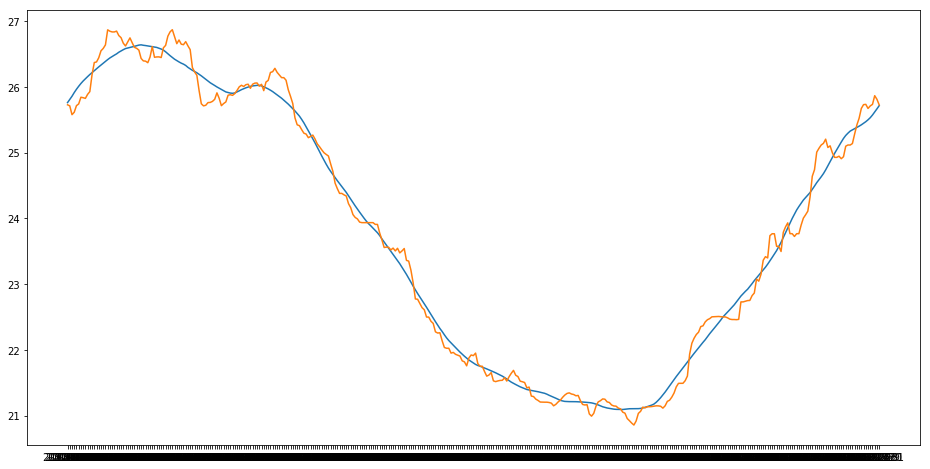

In [40]:
fig = plt.figure(figsize=(16,8))
plt.plot(nintyDF4.loc['20120101':'20121231'][1])
plt.plot(nintyDF3.loc['20120101':'20121231'][1])

**The main function to identify the MHW events and generate statistics. Return two dataframes. 
One contains the summary statistics. The other contains the intensity of the MHW days, so that we can 
generate daily spatial statistics. The function also saves individual MHW files and the summary statistics file.** 

In [29]:
import sys
import os
import numpy as np
from scipy.ndimage import label
import pandas as pd
from datetime import datetime

def do_analysis(sstDiff_data,lonlatDF,amp,outDir):
    
    print(datetime.now())
   
    
    # create a dataframe to store the MHW characteristics for each point
    mhwDF1 = pd.DataFrame()
    #mhwEList = []
    idList = [] # PointID
    noEvents = [] # total number of MHWs events, within the study period
    noDays = [] # total number of MHWs days, within the study period
    totalIntensity = [] # tota accumulated MHWs intensity (oC)
    overallIntensity = [] # overall mean MHWs intensity (oC)
    
    # the event with the highest intensity
    highestIntensity = [] # the maximum intensity of the event (oC)
    date_start_HI = [] # # the start date of the event (as the day number since 20150101)
    duration_HI = [] # the duration of the event
    
    # the event with the longest duration
    largestDuration = [] # the duration of the event 
    date_start_LD = [] # the start date of the event (as the day number since 20150101)
    intensityLD = [] # the mean intensity of the event
    
    # the event with the largest mean intensity
    largestMeanIntensity = [] # the mean intensity of event
    date_start_LMI = [] # the start day of the event (as the day number since 20150101)
    duration_LMI = [] # the duration of the event
    
    # the event with the largest cumulative intensity
    largestCumIntensity = [] # the cumulative intensity of the event
    date_start_LCI = [] # the start day of the event (as the day number since 20150101)
    duration_LCI = [] # the duration of the event
    
    statsDF = pd.DataFrame()
    statsDF['date'] = sstDiff_data.index
    statsDF.set_index('date',inplace=True)
    


   
    # loop through each Point
    for id in sstDiff_data.columns:
        print(str(id))
        idList.append(id)
        # create a dataframe to store characteristics of the MHWs events identified for this point
        mhwE = pd.DataFrame()
        date_start = []
        date_end = []
        duration = []

        # get the point values as a numpy array, the empty value is NaN
        point1 = sstDiff_data[id]
        point1V = point1.values
        dates = sstDiff_data.index.values

        # replace the NaN values with '-9999'
        point1V_1 = np.where(np.isnan(point1V),-9999,point1V)
        # convert negative values into 0 and positive values into 1
        point1V_1[point1V_1<=0] = False
        point1V_1[point1V_1>0] = True
        # label events: positive value(s)
       
        events, n_events = label(point1V_1)
        #print(events)
        #print(n_events)
        for ev in range(1,n_events+1):
            # calculate duration of an event
            event_duration = (events == ev).sum()
            # initially identify all events with duration of 4+ days
            # isolated 4-day event(s) will be eventually removed
            if event_duration > 3:

                date_start.append(dates[np.where(events == ev)[0][0]])
                date_end.append(dates[np.where(events == ev)[0][-1]])
                duration.append(event_duration)
        # the initial list of mhwE
        mhwE['date_start'] = date_start
        mhwE['date_end'] = date_end
        mhwE['duration'] = duration

        # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
        i = 0
        while i < mhwE.index.size - 1:

            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            gap = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if gap < 3:
                # condition 1: [>=5 hot, 1 cool, 4 hot]; condition 2: [4 hot, 1 cool, >=5 hot]; condition 3: [>=5 hot, 1 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] == 4) or  (mhwE.iloc[i]['duration'] == 4 and mhwE.iloc[i+1]['duration'] >=5) or  (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            elif gap < 4:
                # condition 4: [>=5 hot, 2 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 5 and mhwE.iloc[i+1]['duration'] >= 5):              
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            else:
                i = i + 1

        # drop the isolated event(s) with a duration of 4 days from the list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            if duration == 4:
                mhwE = mhwE.drop(i)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1

        # update the durations of the final list
        i = 0
        while i < mhwE.index.size:
            #date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y%m%d')
            #date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y%m%d')
            #duration = (date2 - date1).days + 1
            date1 = str(mhwE.iloc[i]['date_start'])
            date2 = str(mhwE.iloc[i]['date_end'])
            duration = np.where(sstDiff_data.index.values == date2)[0] - np.where(sstDiff_data.index.values == date1)[0] + 1
            mhwE['duration'][i] = duration
            i = i + 1

        # calculate mhw properties: intensity max, intensity mean, intensity std, 
        # cumulative intensity, onset rate and decline rate
        intensity_max = []
        intensity_mean = []
        intensity_std = []
        intensity_cumulative = []

        onset_rate = []
        decline_rate = []
        i = 0
      
        while i < mhwE.index.size:
            intensity_values = []
            date_values = []
            startDate = mhwE.iloc[i]['date_start']
            endDate = mhwE.iloc[i]['date_end']
            duration = mhwE.iloc[i]['duration']

            j = 0
            while j < sstDiff_data.index.size:

                date1 = dates[j]
                if startDate == date1:
                    k = j + int(duration)

                    while j < k:

                        sst_diff = point1V[j]
                        intensity_values.append(sst_diff)
                        dateV = dates[j]
                        date_values.append(dateV)
                        j = j + 1
                else:
                    j = j + 1
            #print('event', i, ':', intensity_values)
            np_intensity = np.array(intensity_values)
            np_date = np.array(date_values)

            startDiff = np_intensity[0]
            endDiff = np_intensity[-1]
            maxDiff = np_intensity.max()
            meanDiff = np_intensity.mean()
            stdDiff = np_intensity.std()
            cumDiff = np_intensity.sum()
      
            peakDate = np_date[np_intensity == maxDiff][0]

            dateDiff1 = (datetime.strptime(str(peakDate),'%Y%m%d') - 
                        datetime.strptime(str(startDate),'%Y%m%d')).days
            if dateDiff1 > 0:        
                rateOnset = (maxDiff - startDiff) / dateDiff1
            else: # the start date is the peak date
                rateOnset = maxDiff / 0.5

            dateDiff2 = (datetime.strptime(str(endDate),'%Y%m%d') - 
                        datetime.strptime(str(peakDate),'%Y%m%d')).days
            if dateDiff2 > 0:        
                rateDecline = (maxDiff - endDiff) / dateDiff2
            else: # the end date is the peak date
                rateDecline = maxDiff / 0.5


            intensity_max.append(maxDiff)
            intensity_mean.append(meanDiff)
            intensity_std.append(stdDiff)
            intensity_cumulative.append(cumDiff)

            onset_rate.append(rateOnset)
            decline_rate.append(rateDecline)
            i = i + 1

        mhwE['maxIntensity'] = intensity_max
        mhwE['meanIntensity'] = intensity_mean
        mhwE['stdIntensity'] = intensity_std
        mhwE['cumIntensity'] = intensity_cumulative

        mhwE['onsetRate'] = onset_rate
        mhwE['declineRate'] = decline_rate

        # save the MHWs events identified for the point into a CSV file
        filename = os.path.join(outDir, 'mhw_' + str(id) + '.csv')
        mhwE.to_csv(filename, sep=',', index=False)
        
        
        # generate a statsDF to extract the intensity for the days identified as part of a MHW
        if mhwE.index.size > 0:
            statsDF[str(id)] = np.nan
            for j in mhwE.index:    
                date_start = str(int(mhwE.loc[j]['date_start']))
                date_end = str(int(mhwE.loc[j]['date_end']))
                statsDF.loc[date_start:date_end,str(id)] = sstDiff_data.loc[date_start:date_end][id].values
         

    #   geneate the summary characteristics of the MHWs    
    #    mhwEList.append(mhwE)
        if mhwE.index.size > 0:

            noEvents.append(mhwE.index.size)
            noDays.append(mhwE['duration'].sum())
            totalIntensity.append(mhwE['cumIntensity'].sum())
            overallIntensity.append(mhwE['cumIntensity'].sum()/mhwE['duration'].sum())

            tempDate = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['date_start']
            HIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599 # date number since 20150101
            HIDuration = mhwE[mhwE['maxIntensity'] == mhwE['maxIntensity'].max()].iloc[0]['duration']
            highestIntensity.append(mhwE['maxIntensity'].max())
            date_start_HI.append(HIDate)
            duration_HI.append(HIDuration)

            tempDate = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['date_start']
            LDDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            intensityLDV = mhwE[mhwE['duration'] == mhwE['duration'].max()].iloc[0]['meanIntensity']
            largestDuration.append(mhwE['duration'].max())
            date_start_LD.append(LDDate)
            intensityLD.append(intensityLDV)


            tempDate = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['date_start']
            LMIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LMIDuration = mhwE[mhwE['meanIntensity'] == mhwE['meanIntensity'].max()].iloc[0]['duration']
            largestMeanIntensity.append(mhwE['meanIntensity'].max())
            date_start_LMI.append(LMIDate)
            duration_LMI.append(LMIDuration)    


            tempDate = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['date_start']
            LCIDate = pd.to_datetime(tempDate, format='%Y%m%d').toordinal() - 735599
            LCIDuration = mhwE[mhwE['cumIntensity'] == mhwE['cumIntensity'].max()].iloc[0]['duration']
            largestCumIntensity.append(mhwE['cumIntensity'].max())
            date_start_LCI.append(LCIDate)
            duration_LCI.append(LCIDuration)
        else:
            noEvents.append(0)
            noDays.append(0)
            totalIntensity.append(0)
            overallIntensity.append(0)

            highestIntensity.append(0)
            date_start_HI.append(0)
            duration_HI.append(0)


            largestDuration.append(0)
            date_start_LD.append(0)
            intensityLD.append(0)


            largestMeanIntensity.append(0)
            date_start_LMI.append(0)
            duration_LMI.append(0)

            largestCumIntensity.append(0)
            date_start_LCI.append(0)
            duration_LCI.append(0)            
        
        
    # populate the dataframe 
    mhwDF1['pointID'] = idList
    mhwDF1['lat'] = latlonDF.lat.values
    mhwDF1['lon'] = latlonDF.lon.values
    #mhwDF1['MHWs'] = mhwEList
    mhwDF1['noEvents'] = noEvents
    mhwDF1['noDays'] = noDays
    mhwDF1['totalIntensity'] = totalIntensity
    mhwDF1['overallIntensity'] = overallIntensity
    
    mhwDF1['highestIntensity'] = highestIntensity
    mhwDF1['date_start_HI'] = date_start_HI
    mhwDF1['duration_HI'] = duration_HI
    
    mhwDF1['largestDuration'] = largestDuration
    mhwDF1['date_start_LD'] = date_start_LD
    mhwDF1['intensityLD'] = intensityLD
    
    mhwDF1['largestMeanIntensity'] = largestMeanIntensity
    mhwDF1['date_start_LMI'] = date_start_LMI
    mhwDF1['duration_LMI'] = duration_LMI
    
    mhwDF1['largestCumIntensity'] = largestCumIntensity
    mhwDF1['date_start_LCI'] = date_start_LCI
    mhwDF1['duration_LCI'] = duration_LCI
    
          
    # save the summary characteristics to a CSV file
    mhwDF1.to_csv(os.path.join(outDir, 'results_' + amp + '.csv'), sep=',', index=False) 
    print(datetime.now())
    return mhwDF1, statsDF


**Apply the main function**

In [30]:
outdir = '/home/547/zxh547/dea-notebooks/mhw_5'
amp = 'LH5'
mhwDF4, statsDF4 = do_analysis(diffDF4,latlonDF,amp,outdir)

2019-04-29 14:23:15.061804
1


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [31]:
mhwDF4.shape

(1088, 19)

In [44]:
mhwDF4.head(10)

,pointID,lat,lon,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,intensityLD,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI
0,1,-28.85,158.25000000000003,9,65,28.022750,0.431119,2.766264,-3910,8,11,-3925,0.718971,0.718971,-3925,11,7.908684,-3925,11
1,2,-28.85,158.35000000000002,14,86,43.128260,0.501491,2.977864,-1404,5,9,-3933,0.337642,1.272566,-1404,5,6.622981,882,6
2,3,-28.85,158.45000000000002,11,63,23.725295,0.376592,1.023938,-3341,7,7,-3921,0.592690,0.707275,-3341,7,4.950928,-3341,7
3,4,-28.85,158.55000000000004,10,65,30.638028,0.471354,2.215690,441,5,15,-3848,0.293147,0.792076,275,5,4.397209,-3848,15
4,5,-28.85,158.65000000000003,11,78,38.909828,0.498844,2.055699,442,16,16,442,0.571025,0.912649,-3967,6,9.136395,442,16
5,6,-28.85,158.75000000000003,9,52,27.816915,0.534941,3.273908,1086,5,7,-3917,0.701270,1.650019,1086,5,8.250094,1086,5
6,7,-28.85,158.85000000000002,9,55,30.592834,0.556233,2.684548,1086,5,8,-3838,0.555487,1.283539,1086,5,6.417693,1086,5
7,8,-28.85,158.95000000000002,8,49,31.369887,0.640202,2.066559,-3980,5,8,-3908,0.535646,1.020344,1086,5,5.315181,-3837,7
8,9,-28.85,159.05000000000004,12,72,32.473924,0.451027,1.879460,1086,5,9,1311,0.311624,0.991506,1086,5,5.221741,-3837,7
9,10,-28.85,159.15000000000003,11,64,30.013082,0.468954,1.968540,1085,6,7,-3837,0.635125,1.130472,1085,6,6.782830,1085,6


In [107]:
mhwDF3.head(10)

,noEvents,noDays,totalIntensity,overallIntensity,highestIntensity,date_start_HI,duration_HI,largestDuration,date_start_LD,intensityLD,largestMeanIntensity,date_start_LMI,duration_LMI,largestCumIntensity,date_start_LCI,duration_LCI
pointID,,,,,,,,,,,,,,,,
1,8,48,27.531170,0.573566,1.461500,-3948,10,10,-3948,0.930951,0.930951,-3948,10,9.309505,-3948,10
2,9,53,28.614260,0.539892,1.913500,-1801,5,9,499,0.294685,1.064000,-1801,5,5.320002,-1801,5
3,6,41,17.476505,0.426256,1.296251,-3968,10,10,-3968,0.672800,0.672800,-3968,10,6.727999,-3968,10
4,6,50,26.060238,0.521205,2.303999,-3968,10,15,980,0.367388,0.896811,-3946,8,7.242998,-3968,10
5,11,69,38.954926,0.564564,1.601000,-1800,6,10,497,0.356800,1.137438,-3968,8,9.099501,-3968,8
6,9,56,33.538845,0.598908,1.604000,-3968,8,8,-3968,1.159605,1.159605,-3968,8,9.276836,-3968,8
7,8,49,21.676680,0.442381,1.357502,271,5,8,-3967,0.704937,0.704937,-3967,8,5.639498,-3967,8
8,8,47,16.140577,0.343417,1.107498,102,6,7,-1600,0.174453,0.549249,102,6,3.295494,102,6
9,8,50,22.952576,0.459052,1.223001,-3968,5,11,-3949,0.497636,0.782899,-3968,5,5.473995,-3949,11


In [45]:
statsDF4.head(10)

,1,2,3,4,5,6,7,8,9,10,...,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088
date,,,,,,,,,,,,,,,,,,,,,
20020704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20020712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**These codes are not used. But we can also generate the second dataframe from the exported files.**

In [601]:
statsDF = pd.DataFrame()
statsDF['date'] = diffDF.index
statsDF.set_index('date',inplace=True)
i = 1
while i < 3601:
    statsDF[str(i)] = np.nan
    mhwFile = '/home/547/zxh547/dea-notebooks/mhw/mhw_' + str(i) + '.csv' 
    mhw = pd.read_csv(mhwFile,sep=',',header=0)
    for j in mhw.index:    
        date_start = str(int(mhw.loc[j]['date_start']))
        date_end = str(int(mhw.loc[j]['date_end']))
        statsDF.loc[date_start:date_end,str(i)] = diffDF.loc[date_start:date_end][i].values
    i += 1

In [56]:
statsDF3 = statsDF3.drop(columns=['min','max','mean','std','count'])

**Calculate summary statistics for the second dataframe**

In [32]:
minList = []
maxList = []
meanList = []
stdList = []
countList = []
for i in statsDF4.index:
    minList.append(statsDF4.loc[i].min())
    maxList.append(statsDF4.loc[i].max())
    meanList.append(statsDF4.loc[i].mean())
    stdList.append(statsDF4.loc[i].std())
    countList.append(statsDF4.loc[i].count())
statsDF4['min'] = minList
statsDF4['max'] = maxList
statsDF4['mean'] = meanList
statsDF4['std'] = stdList
statsDF4['count'] = countList

    

In [50]:
statsDF4.tail(50)

,1,2,3,4,5,6,7,8,9,10,...,1084,1085,1086,1087,1088,min,max,mean,std,count
date,,,,,,,,,,,,,,,,,,,,,
20180824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.404891,1.145764,0.852956,0.394084,3
20180825,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.250863,0.683460,0.518509,0.233869,3
20180826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.094818,0.355770,0.225294,0.184521,2
20180827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.025878,0.025878,0.025878,NaN,1
20180828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
20180829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
20180830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
20180831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
20180901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


**Generate seasonal statistics**

In [33]:
seasonList = ['2002 winter','2002 spring','2002-03 summer','2003 autumn',
              '2003 winter','2003 spring','2003-04 summer','2004 autumn',
             '2004 winter','2004 spring','2004-05 summer','2005 autumn',
             '2005 winter','2005 spring','2005-06 summer','2006 autumn',
             '2006 winter','2006 spring','2006-07 summer','2007 autumn',
             '2007 winter','2007 spring','2007-08 summer','2008 autumn',
             '2008 winter','2008 spring','2008-09 summer','2009 autumn',
             '2009 winter','2009 spring','2009-10 summer','2010 autumn',
             '2010 winter','2010 spring','2010-11 summer','2011 autumn',
             '2011 winter','2011 spring','2011-12 summer','2012 autumn',
             '2012 winter','2012 spring','2012-13 summer','2013 autumn',
             '2013 winter','2013 spring','2013-14 summer','2014 autumn',
             '2014 winter','2014 spring','2014-15 summer','2015 autumn',
             '2015 winter','2015 spring','2015-16 summer','2016 autumn',
             '2016 winter','2016 spring','2016-17 summer','2017 autumn',
             '2017 winter','2017 spring','2017-18 summer','2018 autumn',
             '2018 winter','2018 spring']
seasonDF4 = pd.DataFrame()
seasonDF4['season'] = seasonList
seasonDF4.set_index('season',inplace=True)
minList = []
maxList = []
meanList = []
stdList = []
sumList = []
countList = []
numPoints = statsDF4.columns.size - 5
x=statsDF4.loc['20020704':'20020831','1':str(numPoints)].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)

yearList = ['2002','2003','2004','2005','2006','2007','2008','2009',
            '2010','2011','2012','2013','2014','2015','2016','2017','2018']
i = 0
for year in yearList:
    if year == '2018':
        break
    date1 = year+'0901'
    date2 = year+'1130'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    
    date1 = year+'1201'
    date2 = yearList[i+1] + '0228'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    
    date1 = yearList[i+1] + '0301'
    date2 = yearList[i+1] + '0531'
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    
    date1 = yearList[i+1] + '0601'
    date2 = yearList[i+1] + '0831' 
    print(date1,date2)
    x=statsDF4.loc[date1:date2,'1':str(numPoints)].values
    if x[x>=0].size > 0:
        minList.append(x[x>=0].min())
        maxList.append(x[x>=0].max())
        meanList.append(x[x>=0].mean())
        stdList.append(x[x>=0].std())
        sumList.append(x[x>=0].sum())
        countList.append(x[x>=0].size)
    else:
        minList.append(np.nan)
        maxList.append(np.nan)
        meanList.append(np.nan)
        stdList.append(np.nan)
        sumList.append(np.nan)
        countList.append(0)
    i += 1

x=statsDF4.loc['20180901':'20181012','1':str(numPoints)].values
if x[x>=0].size > 0:
    minList.append(x[x>=0].min())
    maxList.append(x[x>=0].max())
    meanList.append(x[x>=0].mean())
    stdList.append(x[x>=0].std())
    sumList.append(x[x>=0].sum())
    countList.append(x[x>=0].size)
else:
    minList.append(np.nan)
    maxList.append(np.nan)
    meanList.append(np.nan)
    stdList.append(np.nan)
    sumList.append(np.nan)
    countList.append(0)

seasonDF4['min'] = minList
seasonDF4['max'] = maxList
seasonDF4['mean'] = meanList
seasonDF4['std'] = stdList
seasonDF4['sum'] = sumList
seasonDF4['count'] = countList

20020901 20021130
20021201 20030228
20030301 20030531
20030601 20030831
20030901 20031130
20031201 20040228
20040301 20040531
20040601 20040831
20040901 20041130
20041201 20050228
20050301 20050531
20050601 20050831
20050901 20051130
20051201 20060228
20060301 20060531
20060601 20060831
20060901 20061130
20061201 20070228
20070301 20070531
20070601 20070831
20070901 20071130
20071201 20080228
20080301 20080531
20080601 20080831
20080901 20081130
20081201 20090228
20090301 20090531
20090601 20090831
20090901 20091130
20091201 20100228
20100301 20100531
20100601 20100831
20100901 20101130
20101201 20110228
20110301 20110531
20110601 20110831
20110901 20111130
20111201 20120228
20120301 20120531
20120601 20120831
20120901 20121130
20121201 20130228
20130301 20130531
20130601 20130831
20130901 20131130
20131201 20140228
20140301 20140531
20140601 20140831
20140901 20141130
20141201 20150228
20150301 20150531
20150601 20150831
20150901 20151130
20151201 20160228
20160301 20160531
20160601 2

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater_equal
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/

In [34]:
seasonDF4.head(40)

,min,max,mean,std,sum,count
season,,,,,,
2002 winter,NaN,NaN,NaN,NaN,NaN,0
2002 spring,0.000798,1.826857,0.477661,0.367380,43.467179,91
2002-03 summer,NaN,NaN,NaN,NaN,NaN,0
2003 autumn,0.002491,1.733573,0.424975,0.469604,8.499510,20
2003 winter,0.003240,2.393621,0.548692,0.371484,567.896275,1035
2003 spring,0.000026,2.112559,0.431015,0.404237,114.650120,266
2003-04 summer,0.002346,2.736285,0.506099,0.454081,277.342471,548
2004 autumn,0.000390,3.560699,0.695396,0.451173,2486.735161,3576
2004 winter,0.000258,2.222382,0.448736,0.302323,2400.737719,5350


In [67]:
seasonDF3.head(40)

,min,max,mean,std,sum,count
season,,,,,,
2002 winter,0.005333,0.505001,0.180264,0.123045,12.077662,67
2002 spring,0.000250,2.768000,0.609435,0.531276,475.968454,781
2002-03 summer,NaN,NaN,NaN,NaN,NaN,0
2003 autumn,0.042500,1.915499,0.565137,0.485153,9.607336,17
2003 winter,0.000500,1.727501,0.428941,0.336045,646.413548,1507
2003 spring,0.000500,3.469999,0.458573,0.422147,235.247904,513
2003-04 summer,0.000500,4.302999,0.680579,0.573266,762.247984,1120
2004 autumn,0.000500,4.393000,0.608266,0.461652,5139.238688,8449
2004 winter,0.000002,3.689999,0.418445,0.318243,4522.966913,10809


**Plot a figure usign the seasonal statistics. The height of the y-axis shows the number of cells that have been 
identified as MHW days for each season. The colors indicates other statistics, for example the maximum MHW intensity 
in this case.**

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/matplotlib/image.py:857: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  self.axes.set_ylim((ymin, ymax), auto=None)


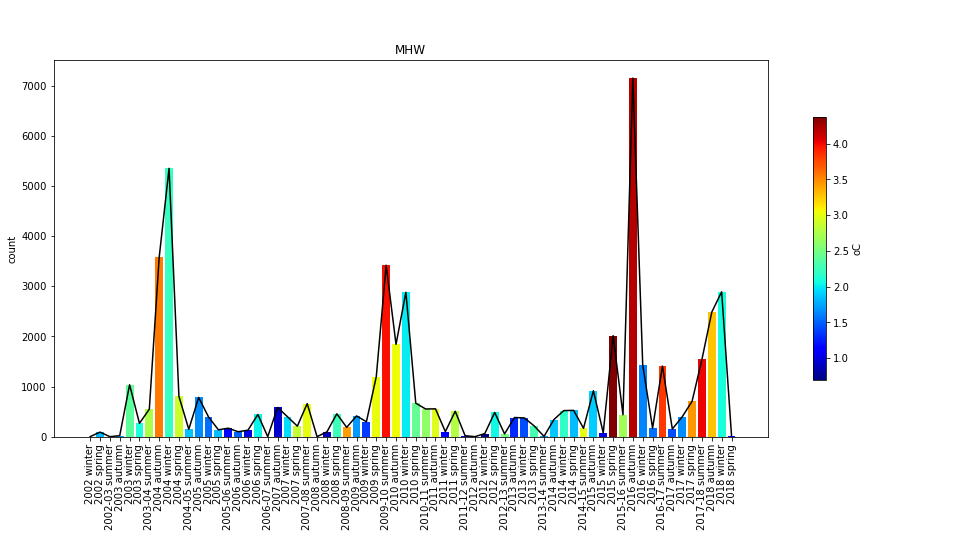

In [35]:
import numpy as np
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(16,8))
cmap = matplotlib.cm.get_cmap('jet')
# two rows, 1 column, first row is 1/20 of the second row in height
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 20])
# set up data
x = seasonDF4.index.values
y = seasonDF4['count'].values
z1 = seasonDF4['max'].values # display as colormap according to its values
z1_min = np.nanmin(z1)
z1_max = np.nanmax(z1)

z2 = (z1 - z1_min) / (z1_max - z1_min) # normalise the data to [0,1], to match the range of the colormap

ax0 = plt.subplot(gs[0]) # the upper row
ax1 = plt.subplot(gs[1]) # the lower row
# plot a line for the lower row
ax1.plot(x, y, color='black', linestyle='-', marker='')
# plot bar one by one with the color matching the value of Z data
i = 0
while i < x.size:     
    ax1.bar(x[i], y[i], facecolor=cmap(z2[i]), alpha=1)
    i += 1

ax1.set_ylabel('count')
ax1.set_title('MHW')
# rotate the x labels, lower row
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
    
# create a dummy image (upper row) using the chosen colormap, so that the colormap can be shown as colorbar for the lower row  
# the purpose is not to show the image by setting the extent with vertical coordinates of '0,0',
# and later turning the axis off; but importantly, needs to set vmin and vmax so that the colorbar display 
# correct max and min values
colors = cmap(np.arange(cmap.N))
ima = ax0.imshow([colors],cmap=cmap,vmin=z1_min,vmax=z1_max,extent=([z1_min,z1_max,0,0]))
ax0.set_axis_off()
# plot the colorbar on the lower row
cbar = plt.colorbar(ima,ax=ax1,shrink=0.7)
cbar.set_label('oC')
plt.show()

**These codes could not accurately do what we want to show here**

0.17 0.7
0.23 0.6222222222222222
0.29 0.5444444444444444
0.35 0.4666666666666666
0.41 0.38888888888888884
0.47 0.31111111111111106
0.5299999999999999 0.23333333333333328
0.59 0.15555555555555545
0.6499999999999999 0.07777777777777772
0.71 0.0


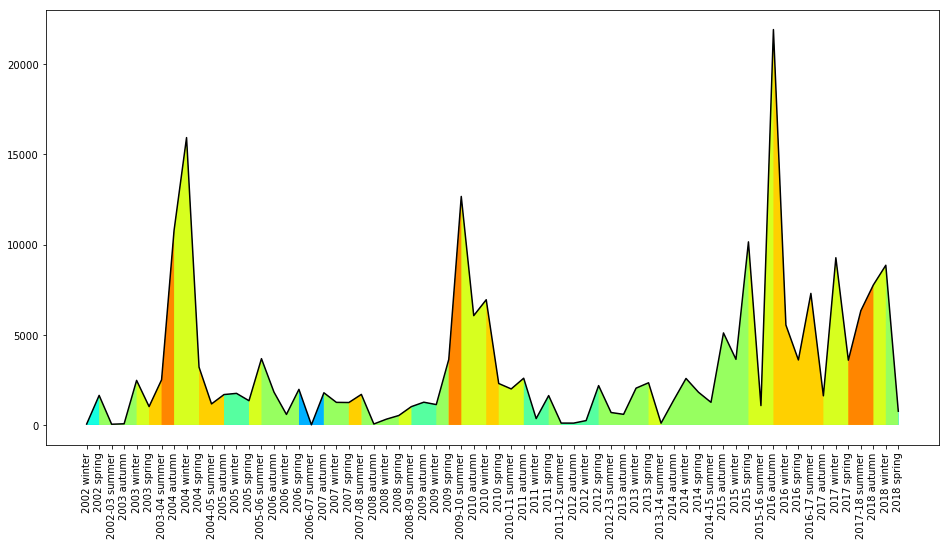

In [224]:
import matplotlib.ticker as ticker
import matplotlib

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
cmap = matplotlib.cm.get_cmap('jet_r')

x = seasonDF.index.values
y = seasonDF['count'].values
z = seasonDF['mean'].values

ax.plot(x, y, color='black', linestyle='-', marker='')
ax.fill_between(x, 0, y, where=z >= 0.17, facecolor=cmap(0.7), alpha=1)

for ii, thresh in enumerate(np.linspace(0.17, 0.71, 10)):    
    color_vals = np.linspace(0.7, 0, 10)
    print(thresh,color_vals[ii])
    ax.fill_between(x, 0, y, where=z >= thresh, facecolor=cmap(color_vals[ii]), alpha=1)

plt.show()

**Add the summary statistics into the 'data' as addiontal variables, so that we can display them 
as maps**

In [54]:
mhwDF4.set_index('pointID',inplace=True)

In [57]:
latSize = data.latitude.size
lonSize = data.longitude.size
noEventsA = mhwDF4['noEvents'].values.reshape(latSize,lonSize)
noDaysA = mhwDF4['noDays'].values.reshape(latSize,lonSize)
totalIntensityA = mhwDF4['totalIntensity'].values.reshape(latSize,lonSize)
overallIntensityA = mhwDF4['overallIntensity'].values.reshape(latSize,lonSize)
highestIntensityA = mhwDF4['highestIntensity'].values.reshape(latSize,lonSize)
date_start_HIA = mhwDF4['date_start_HI'].values.reshape(latSize,lonSize)
largestDurationA = mhwDF4['largestDuration'].values.reshape(latSize,lonSize)
date_start_LDA = mhwDF4['date_start_LD'].values.reshape(latSize,lonSize)
intensityLDA = mhwDF4['intensityLD'].values.reshape(latSize,lonSize)
largestMeanIntensityA = mhwDF4['largestMeanIntensity'].values.reshape(latSize,lonSize)
date_start_LMIA = mhwDF4['date_start_LMI'].values.reshape(latSize,lonSize)
duration_LMIA = mhwDF4['duration_LMI'].values.reshape(latSize,lonSize)
largestCumIntensityA = mhwDF4['largestCumIntensity'].values.reshape(latSize,lonSize)
date_start_LCIA = mhwDF4['date_start_LCI'].values.reshape(latSize,lonSize)
duration_LCIA = mhwDF4['duration_LCI'].values.reshape(latSize,lonSize)


In [58]:
data['noEvents'] = (('latitude','longitude'), noEventsA)
data['noDays'] = (('latitude','longitude'), noDaysA)
data['totalIntensity'] = (('latitude','longitude'), totalIntensityA)
data['overallIntensity'] = (('latitude','longitude'), overallIntensityA)
data['highestIntensity'] = (('latitude','longitude'), highestIntensityA)
data['date_start_HI'] = (('latitude','longitude'), date_start_HIA)
data['largestDuration'] = (('latitude','longitude'), largestDurationA)
data['date_start_LD'] = (('latitude','longitude'), date_start_LDA)
data['intensityLD'] = (('latitude','longitude'), intensityLDA)
data['largestMeanIntensity'] = (('latitude','longitude'), largestMeanIntensityA)
data['date_start_LMI'] = (('latitude','longitude'), date_start_LMIA)
data['duration_LMI'] = (('latitude','longitude'), duration_LMIA)
data['largestCumIntensity'] = (('latitude','longitude'), largestCumIntensityA)
data['date_start_LCI'] = (('latitude','longitude'), date_start_LCIA)
data['duration_LCI'] = (('latitude','longitude'), duration_LCIA)

In [59]:
data

<xarray.Dataset>
Dimensions:               (latitude: 64, longitude: 17, time: 5900)
Coordinates:
  * time                  (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2018-10-12T11:59:59.999999
  * latitude              (latitude) float64 -28.85 -28.95 ... -35.05 -35.15
  * longitude             (longitude) float64 158.3 158.4 158.5 ... 159.8 159.9
Data variables:
    sst                   (time, latitude, longitude) float32 nan nan ... 15.565
    noEvents              (latitude, longitude) int64 9 14 11 10 11 ... 7 5 5 6
    noDays                (latitude, longitude) int64 65 86 63 65 ... 37 32 34
    totalIntensity        (latitude, longitude) float64 28.02 43.13 ... 26.8
    overallIntensity      (latitude, longitude) float64 0.4311 0.5015 ... 0.7882
    highestIntensity      (latitude, longitude) float64 2.766 2.978 ... 1.924
    date_start_HI         (latitude, longitude) int64 -3910 -1404 ... 1134 1302
    largestDuration       (latitude, longitude) int64 11 9 7 15 16 

**Display the summary statistics as maps**

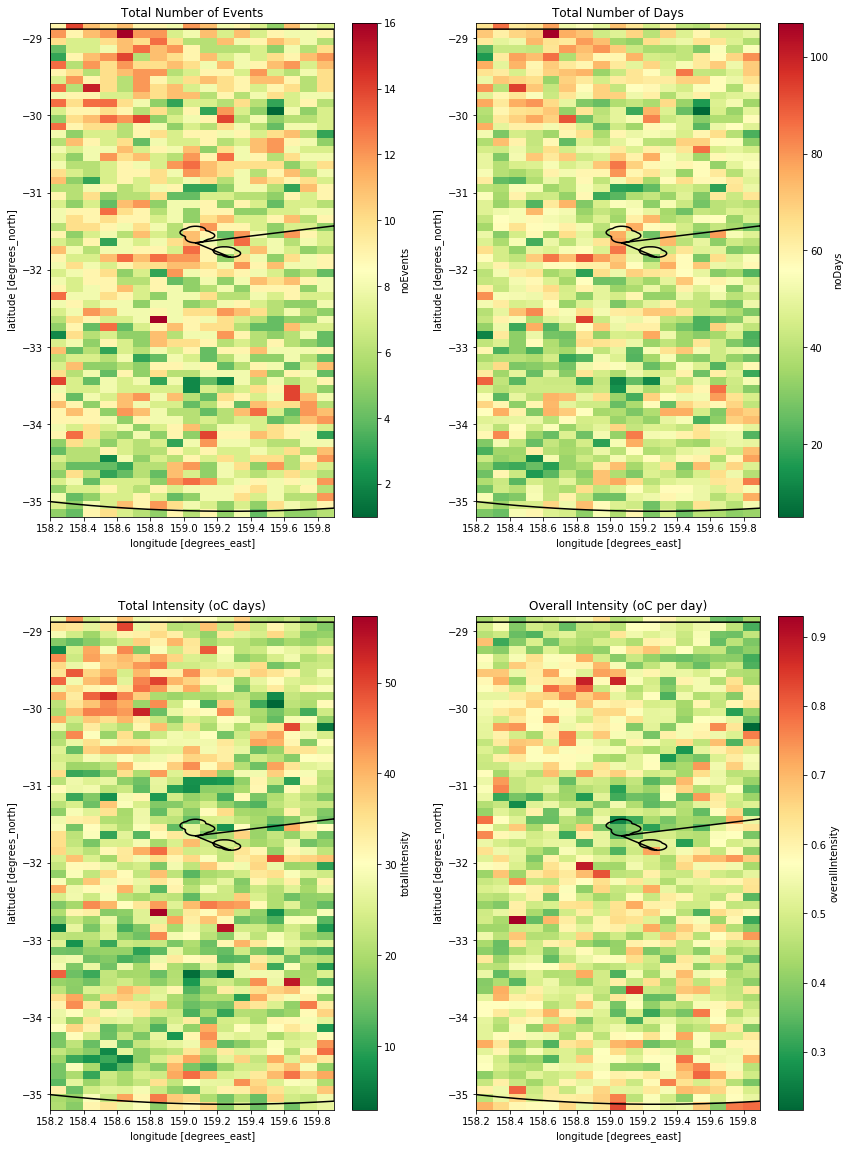

In [60]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.noEvents.plot(cmap='RdYlGn_r')
plt.title('Total Number of Events')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.noDays.plot(cmap='RdYlGn_r')
plt.title('Total Number of Days')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.totalIntensity.plot(cmap='RdYlGn_r')
plt.title('Total Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.overallIntensity.plot(cmap='RdYlGn_r')
plt.title('Overall Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()

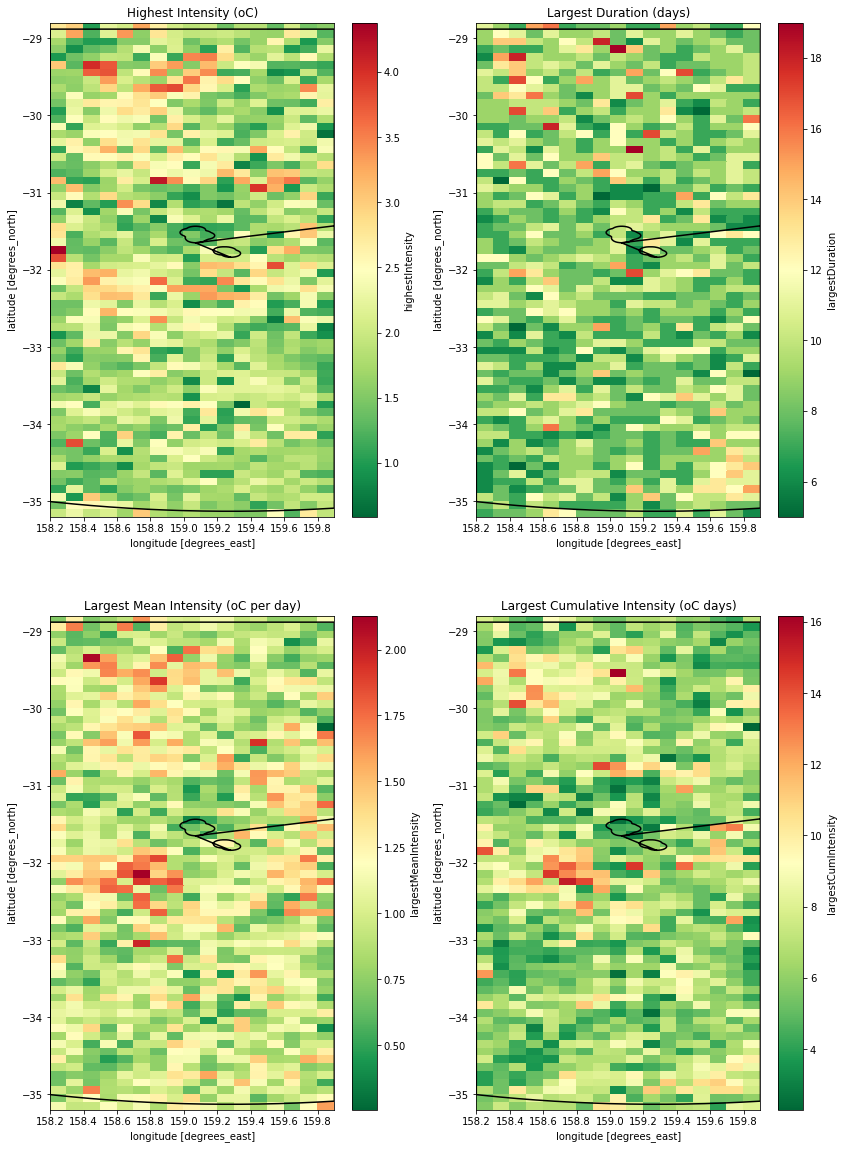

In [61]:
import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/LH_AMP.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(14,20))

plt.subplot(2,2,1)
data.highestIntensity.plot(cmap='RdYlGn_r')
plt.title('Highest Intensity (oC)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
    
plt.subplot(2,2,2)
data.largestDuration.plot(cmap='RdYlGn_r')
plt.title('Largest Duration (days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.subplot(2,2,3)
data.largestMeanIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Mean Intensity (oC per day)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')    

plt.subplot(2,2,4)
data.largestCumIntensity.plot(cmap='RdYlGn_r')
plt.title('Largest Cumulative Intensity (oC days)')
for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')

plt.show()
